# 4. Can you detect cascading failures as delays in one airport create delays in others?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Importing the flight data
data_f = pd.read_csv(r"C:\Users\Ridhwan\Desktop\UOL\PROGRAMMING COURSEWORK\joined_df.csv")
# changing settings to display all columns
pd.set_option("display.max_columns", None)

#### In order to this we need to arrange all the flights in the data set in chronological by date and time order according to scheduled departure time so that we can monitor cascading delays

In [3]:
data_f

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2006,1,11,3,743.0,745,1024.0,1018,US,343,N657AW,281.0,273.0,223.0,6.0,-2.0,ATL,PHX,1587,45,13,0,0,0,0,0
1,2006,1,11,3,1053.0,1053,1313.0,1318,US,613,N834AW,260.0,265.0,214.0,-5.0,0.0,ATL,PHX,1587,27,19,0,0,0,0,0
2,2006,1,11,3,1915.0,1915,2110.0,2133,US,617,N605AW,235.0,258.0,220.0,-23.0,0.0,ATL,PHX,1587,4,11,0,0,0,0,0
3,2006,1,11,3,1753.0,1755,1925.0,1933,US,300,N312AW,152.0,158.0,126.0,-8.0,-2.0,AUS,PHX,872,16,10,0,0,0,0,0
4,2006,1,11,3,824.0,832,1015.0,1015,US,765,N309AW,171.0,163.0,132.0,0.0,-8.0,AUS,PHX,872,27,12,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979491,2005,12,22,4,1652.0,1655,1815.0,1837,DL,901,N109DL,263.0,282.0,241.0,-22.0,-3.0,ATL,ONT,1900,7,15,0,0,0,0,0
13979492,2005,12,22,4,1825.0,1825,1858.0,1848,DL,902,N932DL,93.0,83.0,54.0,10.0,0.0,ATL,MEM,332,7,32,0,0,0,0,0
13979493,2005,12,22,4,1507.0,1511,1641.0,1649,DL,903,N306DL,154.0,158.0,121.0,-8.0,-4.0,ATL,SAT,874,4,29,0,0,0,0,0
13979494,2005,12,22,4,924.0,925,1056.0,1111,DL,904,N981DL,152.0,166.0,129.0,-15.0,-1.0,ATL,MSP,906,4,19,0,0,0,0,0


In [4]:
#We will be monitoring csacading effects by tailnum we will need to remove any values that have a "0" in them
data_f.drop(data_f.loc[data_f['TailNum']== '0'].index, inplace=True)

#### To do this we will be combining "Month","DayofMonth","Year","CRSDepTime", we however need to first format the time in CSRDepTime in to the HR:MIN:SEC format

In [5]:
#Storing hour string
Hour_str = data_f.CRSDepTime.astype(str).str[:-2]
Hour_str

0            7
1           10
2           19
3           17
4            8
            ..
13979491    16
13979492    18
13979493    15
13979494     9
13979495    13
Name: CRSDepTime, Length: 13979282, dtype: object

In [6]:
#Adding a 0 to single digit hours
Hour_str[Hour_str == ""] = "0"
Hour_str

0            7
1           10
2           19
3           17
4            8
            ..
13979491    16
13979492    18
13979493    15
13979494     9
13979495    13
Name: CRSDepTime, Length: 13979282, dtype: object

In [7]:
#Storing Minute string
Minute_str = data_f.CRSDepTime.astype(str).str[-2:]
Minute_str

0           45
1           53
2           15
3           55
4           32
            ..
13979491    55
13979492    25
13979493    11
13979494    25
13979495    44
Name: CRSDepTime, Length: 13979282, dtype: object

In [8]:
#Adding a 0 infront of single character days
Day_str = data_f.DayofMonth.astype(str)
Day_str = Day_str.apply(lambda x: '{0:0>2}'.format(x))
Day_str.value_counts()

27    467675
06    465875
17    465704
20    464361
21    464232
13    463783
07    462604
26    462450
18    462231
14    461570
09    461466
10    461433
19    460946
16    460899
28    460740
08    459797
15    459764
05    459263
02    459201
11    458422
22    458388
01    457759
03    455754
12    455464
04    453941
23    453108
25    452584
24    449140
30    417687
29    414660
31    268381
Name: DayofMonth, dtype: int64

In [9]:
#Adding a 0 infront of single character months
Month_str = data_f.Month.astype(str)
Month_str = Month_str.apply(lambda x: '{0:0>2}'.format(x))
Month_str.value_counts()

08    1230851
07    1218509
03    1201399
05    1201334
06    1182352
10    1179643
04    1162492
12    1144796
01    1136676
09    1134735
11    1134315
02    1052180
Name: Month, dtype: int64

In [10]:
Month_str.value_counts()

08    1230851
07    1218509
03    1201399
05    1201334
06    1182352
10    1179643
04    1162492
12    1144796
01    1136676
09    1134735
11    1134315
02    1052180
Name: Month, dtype: int64

In [11]:
data_f["CRSDepDateTime"] = pd.to_datetime(Day_str + "-" + Month_str + "-" + data_f.Year.astype(str) + "," + Hour_str + ":" + Minute_str, 
                                                     format='%d-%m-%Y,%H:%M')
data_f["CRSDepDateTime"]

0          2006-01-11 07:45:00
1          2006-01-11 10:53:00
2          2006-01-11 19:15:00
3          2006-01-11 17:55:00
4          2006-01-11 08:32:00
                   ...        
13979491   2005-12-22 16:55:00
13979492   2005-12-22 18:25:00
13979493   2005-12-22 15:11:00
13979494   2005-12-22 09:25:00
13979495   2005-12-22 13:44:00
Name: CRSDepDateTime, Length: 13979282, dtype: datetime64[ns]

In [12]:
data_f["CRSDepDateTime"]

0          2006-01-11 07:45:00
1          2006-01-11 10:53:00
2          2006-01-11 19:15:00
3          2006-01-11 17:55:00
4          2006-01-11 08:32:00
                   ...        
13979491   2005-12-22 16:55:00
13979492   2005-12-22 18:25:00
13979493   2005-12-22 15:11:00
13979494   2005-12-22 09:25:00
13979495   2005-12-22 13:44:00
Name: CRSDepDateTime, Length: 13979282, dtype: datetime64[ns]

In [13]:
data_f.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,CRSDepDateTime
0,2006,1,11,3,743.0,745,1024.0,1018,US,343,N657AW,281.0,273.0,223.0,6.0,-2.0,ATL,PHX,1587,45,13,0,0,0,0,0,2006-01-11 07:45:00
1,2006,1,11,3,1053.0,1053,1313.0,1318,US,613,N834AW,260.0,265.0,214.0,-5.0,0.0,ATL,PHX,1587,27,19,0,0,0,0,0,2006-01-11 10:53:00
2,2006,1,11,3,1915.0,1915,2110.0,2133,US,617,N605AW,235.0,258.0,220.0,-23.0,0.0,ATL,PHX,1587,4,11,0,0,0,0,0,2006-01-11 19:15:00
3,2006,1,11,3,1753.0,1755,1925.0,1933,US,300,N312AW,152.0,158.0,126.0,-8.0,-2.0,AUS,PHX,872,16,10,0,0,0,0,0,2006-01-11 17:55:00
4,2006,1,11,3,824.0,832,1015.0,1015,US,765,N309AW,171.0,163.0,132.0,0.0,-8.0,AUS,PHX,872,27,12,0,0,0,0,0,2006-01-11 08:32:00


In [14]:
# Sorting the flights by DateTime_CRSDepTime using the sort_values() function
data_f = data_f.sort_values(by=['CRSDepDateTime'])
data_f

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,CRSDepDateTime
7488483,2005,1,1,6,6.0,10,552.0,614,AS,852,N613AS,286.0,304.0,272.0,-22.0,-4.0,ANC,LAS,2304,7,7,0,0,0,0,0,2005-01-01 00:10:00
7479101,2005,1,1,6,8.0,15,559.0,620,AS,106,N625AS,291.0,305.0,275.0,-21.0,-7.0,ANC,LAX,2345,9,7,0,0,0,0,0,2005-01-01 00:15:00
7536076,2005,1,1,6,34.0,15,754.0,754,DL,2093,N643DL,260.0,279.0,240.0,0.0,19.0,LAS,JFK,2248,6,14,0,0,0,0,0,2005-01-01 00:15:00
7488840,2005,1,1,6,33.0,20,833.0,820,B6,88,N506JB,300.0,300.0,444.0,13.0,13.0,ONT,JFK,2430,26,10,0,0,0,0,0,2005-01-01 00:20:00
7534565,2005,1,1,6,20.0,20,653.0,657,DL,236,N1402A,213.0,217.0,192.0,-4.0,0.0,LAS,ATL,1747,9,12,0,0,0,0,0,2005-01-01 00:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6933014,2006,12,31,7,2349.0,2359,607.0,629,B6,180,N568JB,258.0,270.0,364.0,-22.0,-10.0,PHX,JFK,2153,4,10,0,0,0,0,0,2006-12-31 23:59:00
6704995,2006,12,31,7,2357.0,2359,708.0,702,DL,632,N842MH,311.0,303.0,287.0,6.0,-2.0,HNL,SFO,2398,6,18,0,0,0,0,0,2006-12-31 23:59:00
6558904,2006,12,31,7,10.0,2359,138.0,129,YV,2799,N928LR,88.0,90.0,66.0,9.0,11.0,LAS,SJC,386,5,17,0,0,0,0,0,2006-12-31 23:59:00
6671238,2006,12,31,7,7.0,2359,801.0,743,US,69,N904AW,354.0,344.0,327.0,18.0,8.0,OGG,LAS,2695,13,14,8,0,10,0,0,2006-12-31 23:59:00


In [15]:
# For ease of understanding we will be removing irrelavant rows to easier monitor changes in our dataset

In [16]:
data_f = data_f.filter(["Year", "Month", "DayofMonth","TailNum", "Origin", "Dest", "ArrTime", "CRSArrTime", "DepTime",
                        "CRSDepTime","ArrDelay",
                        "DepDelay", "CRSDepDateTime", "MeanDelay", "LateAircraftDelay"], axis= 1)

In [17]:
data_f

,Year,Month,DayofMonth,TailNum,Origin,Dest,ArrTime,CRSArrTime,DepTime,CRSDepTime,ArrDelay,DepDelay,CRSDepDateTime,LateAircraftDelay
7488483,2005,1,1,N613AS,ANC,LAS,552.0,614,6.0,10,-22.0,-4.0,2005-01-01 00:10:00,0
7479101,2005,1,1,N625AS,ANC,LAX,559.0,620,8.0,15,-21.0,-7.0,2005-01-01 00:15:00,0
7536076,2005,1,1,N643DL,LAS,JFK,754.0,754,34.0,15,0.0,19.0,2005-01-01 00:15:00,0
7488840,2005,1,1,N506JB,ONT,JFK,833.0,820,33.0,20,13.0,13.0,2005-01-01 00:20:00,0
7534565,2005,1,1,N1402A,LAS,ATL,653.0,657,20.0,20,-4.0,0.0,2005-01-01 00:20:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6933014,2006,12,31,N568JB,PHX,JFK,607.0,629,2349.0,2359,-22.0,-10.0,2006-12-31 23:59:00,0
6704995,2006,12,31,N842MH,HNL,SFO,708.0,702,2357.0,2359,6.0,-2.0,2006-12-31 23:59:00,0
6558904,2006,12,31,N928LR,LAS,SJC,138.0,129,10.0,2359,9.0,11.0,2006-12-31 23:59:00,0
6671238,2006,12,31,N904AW,OGG,LAS,801.0,743,7.0,2359,18.0,8.0,2006-12-31 23:59:00,0


In [18]:
# Re arranging rows be in chronological order with respect to each tail number
data_f = data_f.sort_values(["TailNum", "CRSDepDateTime"]).set_index("CRSDepDateTime")
data_f

,Year,Month,DayofMonth,TailNum,Origin,Dest,ArrTime,CRSArrTime,DepTime,CRSDepTime,ArrDelay,DepDelay,LateAircraftDelay
CRSDepDateTime,,,,,,,,,,,,,
2005-01-03 07:15:00,2005,1,3,N050AA,JFK,SJU,1313.0,1207,837.0,715,66.0,82.0,0
2005-01-03 15:25:00,2005,1,3,N050AA,SJU,BOS,1842.0,1828,1547.0,1525,14.0,22.0,0
2005-01-04 09:20:00,2005,1,4,N050AA,BOS,SJU,1356.0,1413,919.0,920,-17.0,-1.0,0
2005-01-04 16:30:00,2005,1,4,N050AA,SJU,JFK,1928.0,1930,1630.0,1630,-2.0,0.0,0
2005-01-06 21:50:00,2005,1,6,N050AA,JFK,SJU,339.0,235,2301.0,2150,64.0,71.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-29 17:58:00,2005,4,29,n816ca,IND,CVG,1954.0,1943,1758.0,1758,11.0,0.0,0
2005-04-29 21:10:00,2005,4,29,n816ca,CVG,MSN,2119.0,2130,2108.0,2110,-11.0,-2.0,0
2005-04-30 05:35:00,2005,4,30,n816ca,MSN,CVG,752.0,800,530.0,535,-8.0,-5.0,0


In [19]:
data_f = data_f.reset_index()
data_f

,CRSDepDateTime,Year,Month,DayofMonth,TailNum,Origin,Dest,ArrTime,CRSArrTime,DepTime,CRSDepTime,ArrDelay,DepDelay,LateAircraftDelay
0,2005-01-03 07:15:00,2005,1,3,N050AA,JFK,SJU,1313.0,1207,837.0,715,66.0,82.0,0
1,2005-01-03 15:25:00,2005,1,3,N050AA,SJU,BOS,1842.0,1828,1547.0,1525,14.0,22.0,0
2,2005-01-04 09:20:00,2005,1,4,N050AA,BOS,SJU,1356.0,1413,919.0,920,-17.0,-1.0,0
3,2005-01-04 16:30:00,2005,1,4,N050AA,SJU,JFK,1928.0,1930,1630.0,1630,-2.0,0.0,0
4,2005-01-06 21:50:00,2005,1,6,N050AA,JFK,SJU,339.0,235,2301.0,2150,64.0,71.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979277,2005-04-29 17:58:00,2005,4,29,n816ca,IND,CVG,1954.0,1943,1758.0,1758,11.0,0.0,0
13979278,2005-04-29 21:10:00,2005,4,29,n816ca,CVG,MSN,2119.0,2130,2108.0,2110,-11.0,-2.0,0
13979279,2005-04-30 05:35:00,2005,4,30,n816ca,MSN,CVG,752.0,800,530.0,535,-8.0,-5.0,0
13979280,2005-04-30 14:50:00,2005,4,30,n816ca,CVG,MCO,1702.0,1700,1450.0,1450,2.0,0.0,0


In [20]:
#We will be monitoring total delays for each flight log which would be Arrival + Departure Delay
data_f["PrevDelay"] = data_f['ArrDelay'].shift(periods=1)
data_f

,CRSDepDateTime,Year,Month,DayofMonth,TailNum,Origin,Dest,ArrTime,CRSArrTime,DepTime,CRSDepTime,ArrDelay,DepDelay,LateAircraftDelay,PrevDelay
0,2005-01-03 07:15:00,2005,1,3,N050AA,JFK,SJU,1313.0,1207,837.0,715,66.0,82.0,0,NaN
1,2005-01-03 15:25:00,2005,1,3,N050AA,SJU,BOS,1842.0,1828,1547.0,1525,14.0,22.0,0,66.0
2,2005-01-04 09:20:00,2005,1,4,N050AA,BOS,SJU,1356.0,1413,919.0,920,-17.0,-1.0,0,14.0
3,2005-01-04 16:30:00,2005,1,4,N050AA,SJU,JFK,1928.0,1930,1630.0,1630,-2.0,0.0,0,-17.0
4,2005-01-06 21:50:00,2005,1,6,N050AA,JFK,SJU,339.0,235,2301.0,2150,64.0,71.0,0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979277,2005-04-29 17:58:00,2005,4,29,n816ca,IND,CVG,1954.0,1943,1758.0,1758,11.0,0.0,0,17.0
13979278,2005-04-29 21:10:00,2005,4,29,n816ca,CVG,MSN,2119.0,2130,2108.0,2110,-11.0,-2.0,0,11.0
13979279,2005-04-30 05:35:00,2005,4,30,n816ca,MSN,CVG,752.0,800,530.0,535,-8.0,-5.0,0,-11.0
13979280,2005-04-30 14:50:00,2005,4,30,n816ca,CVG,MCO,1702.0,1700,1450.0,1450,2.0,0.0,0,-8.0


In [21]:
data_f.isnull().sum()

CRSDepDateTime       0
Year                 0
Month                0
DayofMonth           0
TailNum              0
Origin               0
Dest                 0
ArrTime              0
CRSArrTime           0
DepTime              0
CRSDepTime           0
ArrDelay             0
DepDelay             0
LateAircraftDelay    0
PrevDelay            1
dtype: int64

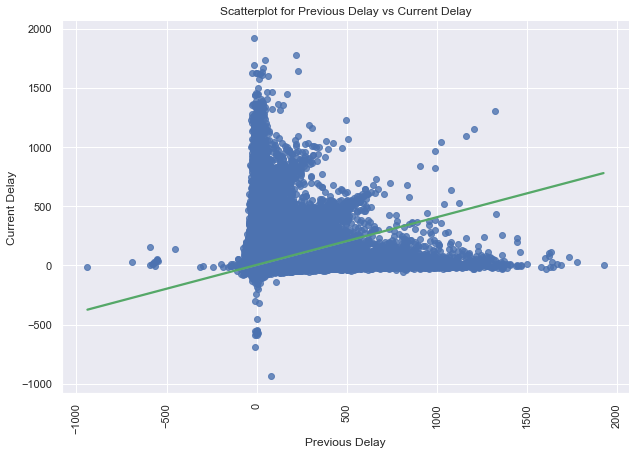

In [23]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lmplot(data= data_f , x="PrevDelay",y="ArrDelay",line_kws={'color': 'g'}, height= 6,
           aspect=1.5).set(title="Scatterplot for Previous Delay vs Current Delay", xlabel="Previous Delay",ylabel="Current Delay")
plt.xticks(rotation=90)
plt.savefig("Scatter of Previous delay vs Current delay.png")
plt.show()

In [34]:
data_f

,CRSDepDateTime,Year,Month,DayofMonth,TailNum,Origin,Dest,ArrTime,CRSArrTime,DepTime,CRSDepTime,ArrDelay,DepDelay,LateAircraftDelay,PrevDelay
0,2005-01-03 07:15:00,2005,1,3,N050AA,JFK,SJU,1313.0,1207,837.0,715,66.0,82.0,0,NaN
1,2005-01-03 15:25:00,2005,1,3,N050AA,SJU,BOS,1842.0,1828,1547.0,1525,14.0,22.0,0,66.0
2,2005-01-04 09:20:00,2005,1,4,N050AA,BOS,SJU,1356.0,1413,919.0,920,-17.0,-1.0,0,14.0
3,2005-01-04 16:30:00,2005,1,4,N050AA,SJU,JFK,1928.0,1930,1630.0,1630,-2.0,0.0,0,-17.0
4,2005-01-06 21:50:00,2005,1,6,N050AA,JFK,SJU,339.0,235,2301.0,2150,64.0,71.0,0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979277,2005-04-29 17:58:00,2005,4,29,n816ca,IND,CVG,1954.0,1943,1758.0,1758,11.0,0.0,0,17.0
13979278,2005-04-29 21:10:00,2005,4,29,n816ca,CVG,MSN,2119.0,2130,2108.0,2110,-11.0,-2.0,0,11.0
13979279,2005-04-30 05:35:00,2005,4,30,n816ca,MSN,CVG,752.0,800,530.0,535,-8.0,-5.0,0,-11.0
13979280,2005-04-30 14:50:00,2005,4,30,n816ca,CVG,MCO,1702.0,1700,1450.0,1450,2.0,0.0,0,-8.0
